# Wind Power Forecasting 

TODO:
- [X] Load in data and inspect columns
- [X] Check for na values
- [ ] Experiment with methods of filling values in feature cols (plot time series data to see effects)
    - [ ] Global mean 
    - [ ] Local mean 
    - [ ] Mean between two points 
- [ ] Handle missing values in target col (ActivePower?)
- [ ] Descriptive Statistics fo data set
- [ ] Correlation analysis
    - [ ] Univariate analysis
    - [ ] Bivariate analysis
    - [ ] Multivariate analysis
- [ ] Time Series Analysis (Uni vs multi variates)
    - [ ] Time series line plots 
    - [ ] Period plots
    - [ ] General trend
    - [ ] Is there seasonality or cyclical changes 
    - [ ] Can the data be fit to a time series model (eg trend model or seasonality model)
    - [ ] Is the dat auto or partially correlation of the data?
    - [ ] Resampling 
    - [ ] Stationary processes 
    - [ ] Decomposition
    - [ ] Look into specific methods for multivariate time series analysis 




In [21]:
import pandas as pd
import numpy as np
import missingno as msno
import os 

pd.set_option('display.max_columns', 50)

## Load data

In [11]:
raw_turbine_path = os.path.join(os.pardir, 'data', 'Turbine_Data.csv')
raw_turbine_data = pd.read_csv(raw_turbine_path)

### Examining Data

In [10]:
raw_turbine_data.head()

,Unnamed: 0,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,ControlBoxTemperature,GearboxBearingTemperature,GearboxOilTemperature,...,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WTG,WindDirection,WindSpeed
0,2017-12-31 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
1,2017-12-31 00:10:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
2,2017-12-31 00:20:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
3,2017-12-31 00:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
4,2017-12-31 00:40:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN


In [9]:
raw_turbine_data.tail()

,Unnamed: 0,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,ControlBoxTemperature,GearboxBearingTemperature,GearboxOilTemperature,...,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WTG,WindDirection,WindSpeed
118219,2020-03-30 23:10:00+00:00,70.044465,27.523741,45.711129,1.515669,1.950088,1.950088,0.0,59.821165,55.193793,...,58.148777,39.008931,36.476562,178.0,13.775785,9.234004,2.0,G01,178.0,3.533445
118220,2020-03-30 23:20:00+00:00,40.833474,27.602882,45.598573,1.702809,2.136732,2.136732,0.0,59.142038,54.798545,...,57.550367,39.006759,36.328125,178.0,8.088928,9.229370,2.0,G01,178.0,3.261231
118221,2020-03-30 23:30:00+00:00,20.777790,27.560925,45.462045,1.706214,2.139664,2.139664,0.0,58.439439,54.380456,...,57.099335,39.003815,36.131944,178.0,4.355978,9.236802,2.0,G01,178.0,3.331839
118222,2020-03-30 23:40:00+00:00,62.091039,27.810472,45.343827,1.575352,2.009781,2.009781,0.0,58.205413,54.079014,...,56.847239,39.003815,36.007805,190.0,12.018077,9.237374,2.0,G01,190.0,3.284468
118223,2020-03-30 23:50:00+00:00,68.664425,27.915828,45.231610,1.499323,1.933124,1.933124,0.0,58.581716,54.080505,...,56.741040,39.003815,35.914062,203.0,14.439669,9.235532,2.0,G01,203.0,3.475205


Initial observation shows that the top of the file is missing data, while the bottom not so much.
We should plot nans over time to see if this was start up issues more common at the start of data collection. 

In [48]:
# we can alternatively use the df.info here but this has a prettier output

info_df = pd.concat([raw_turbine_data.dtypes, raw_turbine_data.count(), raw_turbine_data.isna().sum()], axis=1).reset_index()\
            .rename(columns={'index':'feature', 0:'dtype', 1:'# values', 2:'# na'})
info_df['% missing'] = np.ceil((info_df['# na']*100)/len(raw_turbine_data))
info_df

,feature,dtype,# values,# na,% missing
0,Unnamed: 0,object,118224,0,0.0
1,ActivePower,float64,94750,23474,20.0
2,AmbientTemperatue,float64,93817,24407,21.0
3,BearingShaftTemperature,float64,62518,55706,48.0
4,Blade1PitchAngle,float64,41996,76228,65.0
5,Blade2PitchAngle,float64,41891,76333,65.0
6,Blade3PitchAngle,float64,41891,76333,65.0
7,ControlBoxTemperature,float64,62160,56064,48.0
8,GearboxBearingTemperature,float64,62540,55684,48.0
9,GearboxOilTemperature,float64,62438,55786,48.0


<AxesSubplot:>

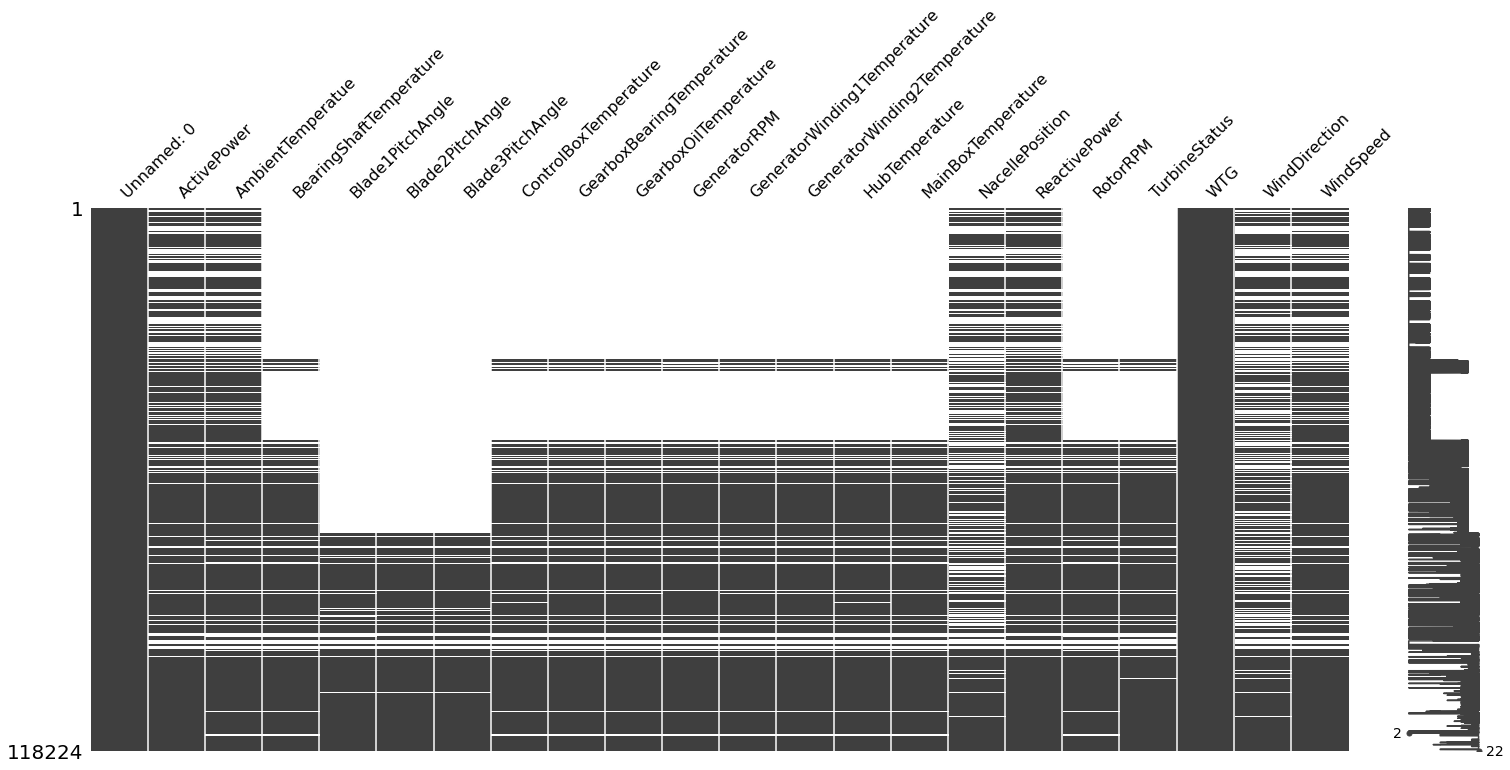

In [18]:
msno.matrix(raw_turbine_data)